In [34]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, activations, optimizers, losses, metrics
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

(28, 28)
(32, 32)
(32, 32, 1)


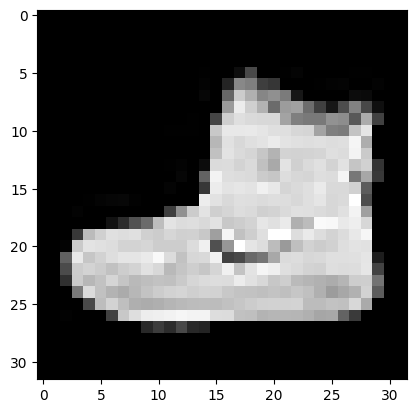

In [3]:
img = x_train[0]
img= img.astype(np.float32) / 255.
print(img.shape)
img = np.pad(img, ((2, 2), (2, 2)), constant_values=0.0)
print(img.shape)
img = np.expand_dims(img, -1)
print(img.shape)

plt.imshow(img, cmap='gray')

In [4]:
def preprocess(images):
    images = images.astype(np.float32) / 255.
    images = np.pad(images, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    images = np.expand_dims(images, -1)

    return images

In [5]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

### Regular Autoencoder

In [6]:
encoder_input = layers.Input(shape=(32, 32, 1), name='encoder_input')
x = layers.Conv2D(32, (3, 3), strides=2, activation=activations.relu, padding='same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation=activations.relu, padding='same')(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation=activations.relu, padding='same')(x)
x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name='encoder_output')(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder_model')
encoder.summary()

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 967

2024-03-18 16:48:19.075628: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-03-18 16:48:19.075650: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-03-18 16:48:19.075655: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-03-18 16:48:19.075687: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-18 16:48:19.075703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
decoder_input = keras.Input(shape=(2,), name='decoder_input')
x = layers.Dense(4 * 4 * 128)(decoder_input)
x = layers.Reshape((4, 4, 128))(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation=activations.relu, padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation=activations.relu, padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation=activations.relu, padding='same')(x)
decoder_output = layers.Conv2DTranspose(1, (3, 3), strides=1, activation=activations.sigmoid, padding='same', name='decoder_output')(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder_model')
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)      

In [8]:
autoencoder = keras.Model(encoder_input, decoder(encoder_output), name='autoencoder_model')
autoencoder.summary()

Model: "autoencoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 decoder_model (Functional)  (None, 32, 32, 1)   

In [9]:
autoencoder.compile(optimizer=optimizers.Adam(),
                    loss=losses.BinaryCrossentropy())

history = autoencoder.fit(x_train,
                          x_train,
                          epochs=5,
                          batch_size=100,
                          shuffle=True,
                          validation_data=(x_test, x_test))

Epoch 1/5


2024-03-18 16:48:20.008410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-18 16:48:20.068805: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


600/600 [==============================] - 11s 16ms/step - loss: 0.2901 - val_loss: 0.2617
Epoch 2/5
600/600 [==============================] - 9s 15ms/step - loss: 0.2574 - val_loss: 0.2567
Epoch 3/5
600/600 [==============================] - 9s 15ms/step - loss: 0.2542 - val_loss: 0.2544
Epoch 4/5
600/600 [==============================] - 9s 15ms/step - loss: 0.2523 - val_loss: 0.2526
Epoch 5/5
600/600 [==============================] - 9s 15ms/step - loss: 0.2507 - val_loss: 0.2518


313/313 [==============================] - 2s 5ms/step


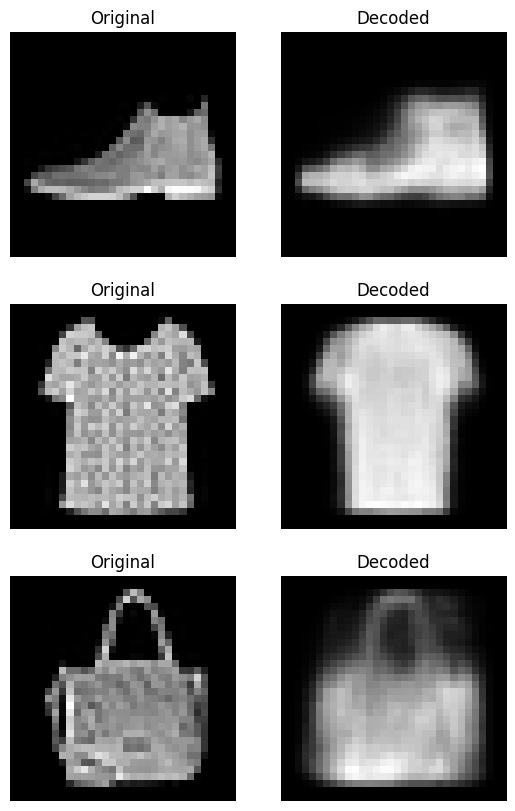

In [10]:
fig, axs = plt.subplots(3, 2)
fig.set_figheight(10)

decoded = autoencoder.predict(x_test)

for i in range(3):
    ax = axs[i,0]
    ax.set_title('Original')
    ax.axis('off')
    ax.imshow(x_test[1000 * i], cmap='gray')

    ax = axs[i,1]
    ax.set_title('Decoded')
    ax.axis('off')
    ax.imshow(decoded[1000 * i], cmap='gray')

### Variatoional Autoencoder

In [6]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        # TODO: Try switching these shape statements up
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))

        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
encoder_input = layers.Input(shape=(32, 32, 1), name='encoder_input')
x = layers.Conv2D(32, (3, 3), strides=2, activation=activations.relu, padding='same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation=activations.relu, padding='same')(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation=activations.relu, padding='same')(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(2, name='z_mean')(x)
z_log_var = layers.Dense(2, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))

encoder = keras.Model(encoder_input, (z_mean, z_log_var, z), name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

2024-03-18 17:47:30.841673: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-03-18 17:47:30.841696: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-03-18 17:47:30.841703: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-03-18 17:47:30.841738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-18 17:47:30.841757: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
decoder_input = keras.Input(shape=(2,), name='decoder_input')
x = layers.Dense(4 * 4 * 128)(decoder_input)
x = layers.Reshape((4, 4, 128))(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation=activations.relu, padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation=activations.relu, padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation=activations.relu, padding='same')(x)
decoder_output = layers.Conv2DTranspose(1, (3, 3), strides=1, activation=activations.sigmoid, padding='same', name='decoder_output')(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder_model')
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)      

In [8]:
class VariationalAutoEncoder(keras.Model):

    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = metrics.Mean(name='kl_loss')
    
    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction
    
    def train_step(self, data):

        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(500 * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))) # beta = 500
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {metric.name: metric.result() for metric in self.metrics}

In [11]:
vae = VariationalAutoEncoder(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())
vae.fit(x_train,
        epochs=5,
        batch_size=100)

Epoch 1/5


2024-03-18 17:47:40.639853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-18 17:47:40.711889: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


600/600 [==============================] - 11s 16ms/step - total_loss: 153.1747 - reconstruction_loss: 148.8260 - kl_loss: 4.3487
Epoch 2/5
600/600 [==============================] - 10s 16ms/step - total_loss: 134.0613 - reconstruction_loss: 129.1007 - kl_loss: 4.9606
Epoch 3/5
600/600 [==============================] - 10s 16ms/step - total_loss: 132.7745 - reconstruction_loss: 127.7195 - kl_loss: 5.0550
Epoch 4/5
600/600 [==============================] - 10s 16ms/step - total_loss: 132.1354 - reconstruction_loss: 127.0141 - kl_loss: 5.1214
Epoch 5/5
600/600 [==============================] - 10s 17ms/step - total_loss: 131.6184 - reconstruction_loss: 126.4450 - kl_loss: 5.1734


313/313 [==============================] - 2s 5ms/step


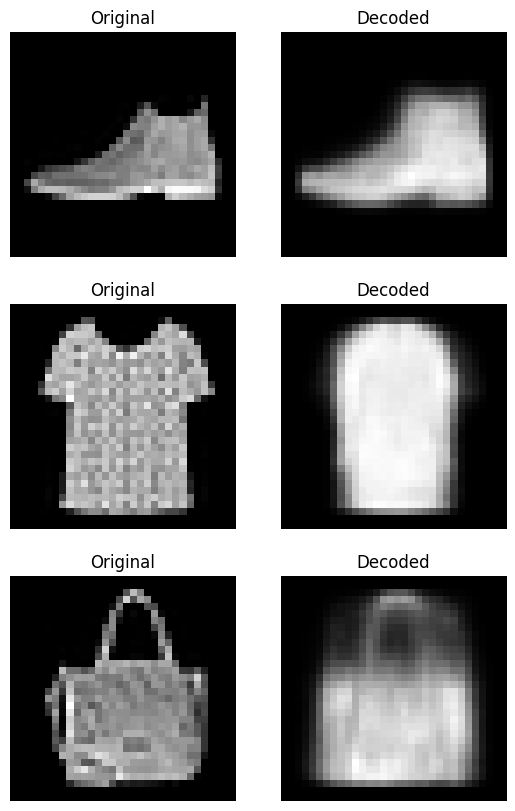

In [20]:
fig, axs = plt.subplots(3, 2)
fig.set_figheight(10)

z_mean, z_log_var, reconstructions = vae.predict(x_test)

for i in range(3):
    ax = axs[i,0]
    ax.set_title('Original')
    ax.axis('off')
    ax.imshow(x_test[1000 * i], cmap='gray')

    ax = axs[i,1]
    ax.set_title('Decoded')
    ax.axis('off')
    ax.imshow(reconstructions[1000 * i], cmap='gray')

#### Generate using the VAE

In [43]:
z_mean, z_var, z = vae.predict(x_test)

313/313 [==============================] - 2s 5ms/step


Text(0.5, 1.0, 'Original Embeddings')

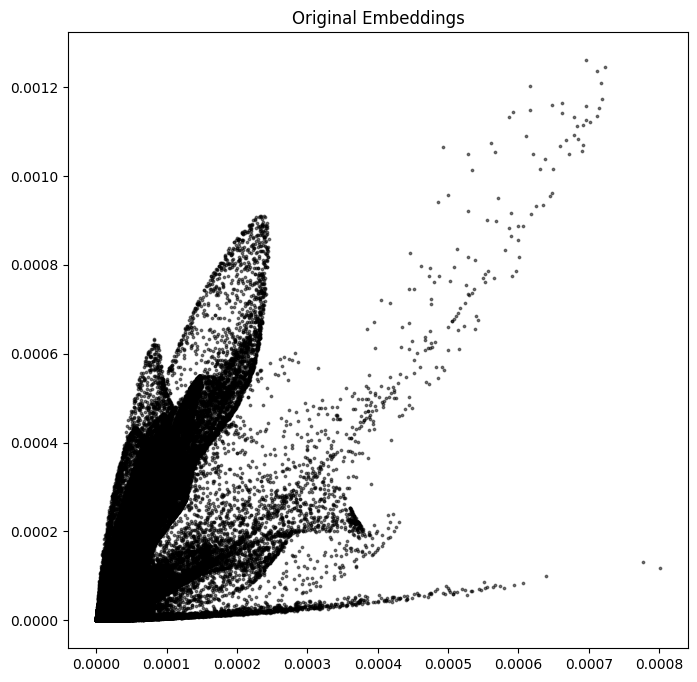

In [47]:
plt.figure(figsize=(8,8))
plt.scatter(z[:, 0], z[:, 1], c='black', alpha=0.5, s=3)
# plt.scatter(z_sample[:, 0], z_sample[:, 1], c='#00B0F0', alpha=1, s=40)
plt.title('Original Embeddings')

In [45]:
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(z[:, 0], z[:, 1], c='black', alpha=0.5, s=3)

In [32]:
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 14ms/step


In [35]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

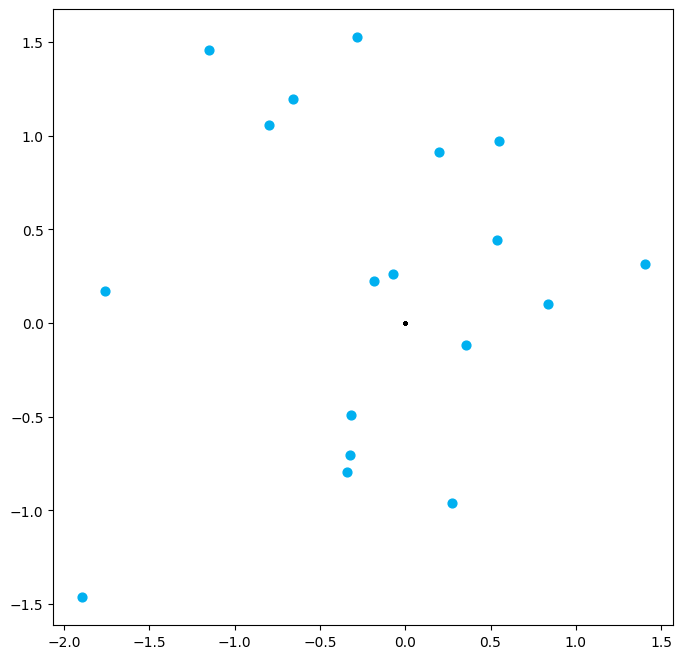

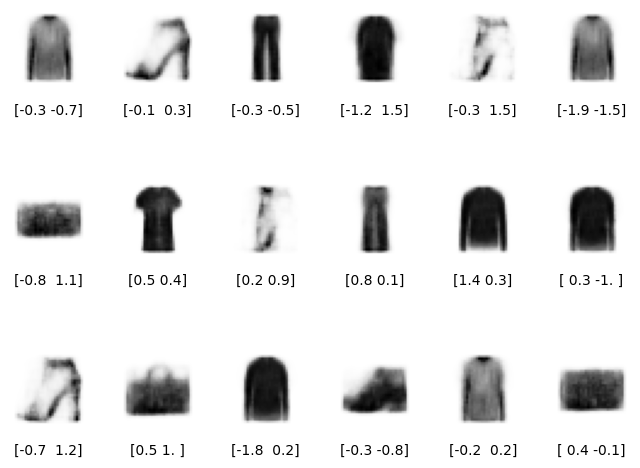

In [48]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")